# Assignment 3 - Task 2

### Explore the solution space for circles, and moons. Datasets also provided in code of Module 6 (25)

1. Find best kernel function
2. Visualize and explain solution

Contents:

1. Import Libraries

2. Create Explorer Class

3. Creating Circles Dataset and Explore

4. Creating Moons Dataset and Explore

5. Evaluate the Kernels and Noise

6. Explain Solution

### 1. Import Libraries

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


### 2. Create Explorer Class


In [55]:
class KernelSVMExplorer:
    def __init__(self, kernels=['linear', 'poly', 'rbf', 'sigmoid']):
        """
        Initiallize the class with kernel options
        """
        self.kernels = kernels


    def generate_dataset(self, dataset_name='moons', **kwargs):
        """
        generate dataset using the specified name to make it modular.
        """
        # pick dataset 
        if dataset_name == 'moons':
            X, y = make_moons(**kwargs)
        elif dataset_name == 'circles':
            X, y = make_circles(**kwargs)
        else:
            raise ValueError("Error check input")
        return X, y
    
    # 3. Visualize Dataset
    def visualize_dataset(self, X, y, dataset_name):
        """
        plots the dataset with
        """
        # create figure
        plt.figure(figsize=(8, 6))
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
        
        #add labels and title
        plt.title(f"{dataset_name.capitalize()} Dataset")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate_kernel(self, X_train, X_test, y_train, y_test, kernel):
        """
        train and evaluate SVM given the data and kernel
        """
        # create model and fit
        model = SVC(kernel=kernel, probability=True)
        model.fit(X_train, y_train)
        
        # get output
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if kernel != 'linear' else None
        
        # get metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
        return {"Kernel": kernel, "Accuracy": accuracy, "ROC-AUC": roc_auc}

    def find_best_kernel(self, X, y):
        """
        Extends the evaluate_kernel method above to find the best kernel
        """
        
        # train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        results = []
        
        # iterate over the kernels and evaluate each
        for kernel in self.kernels:
            metrics = self.evaluate_kernel(X_train, X_test, y_train, y_test, kernel)
            
            # Handle "N/A" to avoud error
            if metrics["ROC-AUC"] == "N/A":
                metrics["ROC-AUC"] = 0.0
            
            results.append(metrics)
    
        # sort by acc, then ROC-AUC
        sorted_results = sorted(results, key=lambda x: (x['Accuracy'], x['ROC-AUC']), reverse=True)
        return sorted_results[0] 

    def plot_decision_boundary(self, model, X, y, kernel, dataset_name):
        """
        Implementation from SKlearn to plot the decision boundary
        """
        
        # create plot
        plt.figure(figsize=(8, 6))
        plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
        plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
        
        # create mesh grid, code is based on SKLEARN's implementation
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot the title and legend
        plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
        plt.title(f"{dataset_name.capitalize()} - Kernel: {kernel}")
        plt.legend()
        plt.show()

    def analyze_and_visualize(self, dataset_name='moons', **kwargs):
        """
        finds the best kernel and metrics automatically
        """
        # Split dataset
        X, y = self.generate_dataset(dataset_name, **kwargs)
        self.visualize_dataset(X, y, dataset_name)
        
        # Get best kernel
        best_kernel_metrics = self.find_best_kernel(X, y)
        print(f"Best Kernel for {dataset_name}: {best_kernel_metrics['Kernel']}")
        print(f"Accuracy: {best_kernel_metrics['Accuracy']}, ROC-AUC: {best_kernel_metrics['ROC-AUC']}")
        
        # Train final model
        best_model = SVC(kernel=best_kernel_metrics['Kernel'])
        best_model.fit(X, y)
        
        # Visualize decision boundary
        self.plot_decision_boundary(best_model, X, y, best_kernel_metrics['Kernel'], dataset_name)

    def evaluate_kernels_with_noise(self, dataset_names=['moons', 'circles'], noise_levels=[0.1, 0.2, 0.3]):
        """
        evaluate each kernel and noise levels for both datasets. Return DF.
        """
        results = []
        
        # loop over the datasets
        for dataset_name in dataset_names:
            
            # loop over noises
            for noise in noise_levels:
                X, y = self.generate_dataset(dataset_name, noise=noise, n_samples=200, random_state=1)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
                
                # loop over kernels
                for kernel in self.kernels:
                    metrics = self.evaluate_kernel(X_train, X_test, y_train, y_test, kernel)
                    metrics.update({"Dataset": dataset_name, "Noise": noise})
                    results.append(metrics)
        
        # create the DF and return
        df_results = pd.DataFrame(results)
        return df_results
    
    from sklearn.model_selection import cross_val_score

    def evaluate_kernels_with_noise_cross_validation(self, dataset_names=['moons', 'circles'], noise_levels=[0.1, 0.2, 0.3], k=5):
        """
        eval kernels across noise levels but with  f fold cross validation
        """
        results = []
        
        # loop datasets
        for dataset_name in dataset_names:
            
            # loop nise
            for noise in noise_levels:
                X, y = self.generate_dataset(dataset_name, noise=noise, n_samples=200, random_state=1)
                
                # loop kernels
                for kernel in self.kernels:
                    model = SVC(kernel=kernel, probability=True, random_state=1)
                    
                    # k-fold CV
                    scores = cross_val_score(model, X, y, cv=k, scoring='accuracy')
                    mean_accuracy = scores.mean()
                    
                    # capture metrics
                    metrics = {
                        "Kernel": kernel,
                        "Dataset": dataset_name,
                        "Noise": noise,
                        "k-Fold CV Accuracy": mean_accuracy
                    }
                    results.append(metrics)
        
        df_results = pd.DataFrame(results)
        return df_results


### 3. Creating Circles Dataset and Explore


In [56]:
# Instantiate the class
explorer = KernelSVMExplorer()


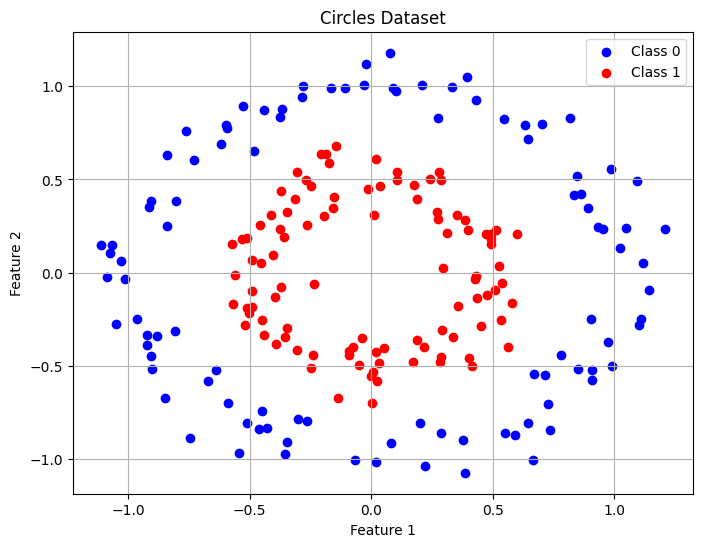

Best Kernel for circles: rbf
Accuracy: 0.9833333333333333, ROC-AUC: 1.0


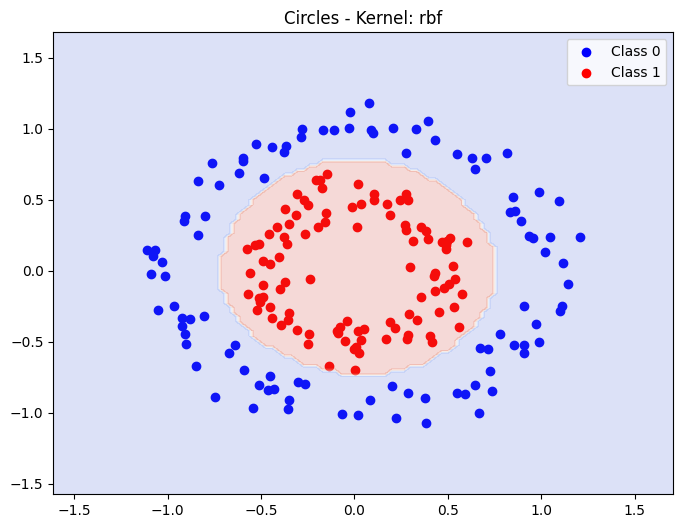

In [57]:
# Generate and analyze the circles dataset
explorer.analyze_and_visualize('circles', n_samples=200, factor=0.5, noise=0.1, random_state=1)


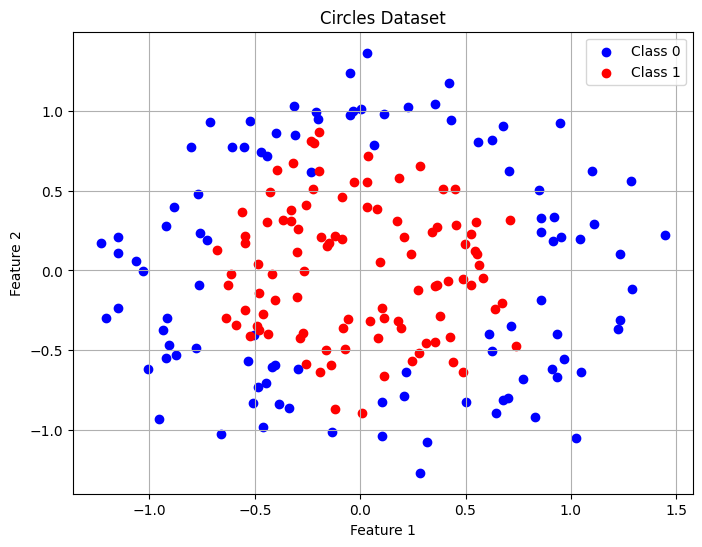

Best Kernel for circles: rbf
Accuracy: 0.8833333333333333, ROC-AUC: 0.9927048260381593


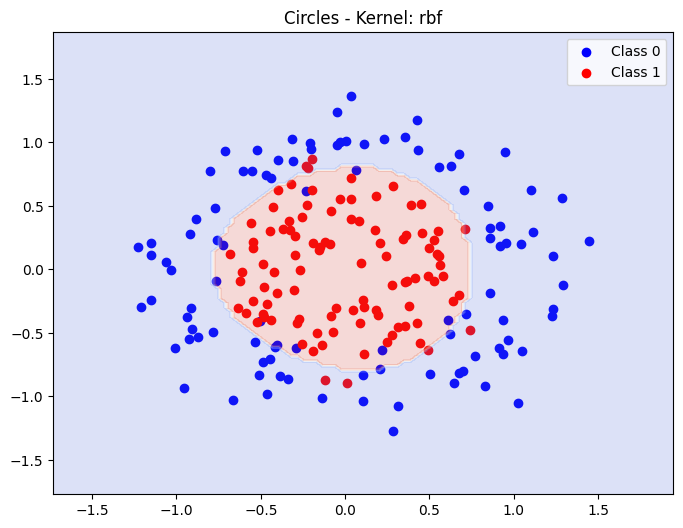

In [58]:
explorer.analyze_and_visualize('circles', n_samples=200, factor=0.5, noise=0.2, random_state=1)


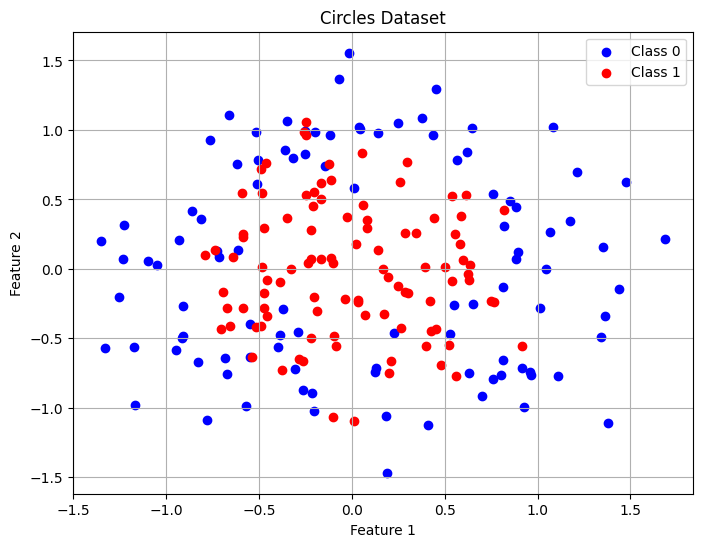

Best Kernel for circles: rbf
Accuracy: 0.75, ROC-AUC: 0.9393939393939394


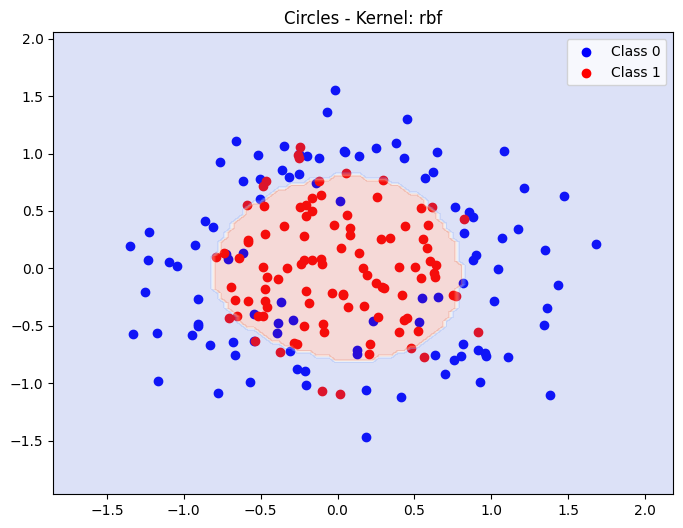

In [59]:
explorer.analyze_and_visualize('circles', n_samples=200, factor=0.5, noise=0.3, random_state=1)


### 4. Creating Moons Dataset and Explore


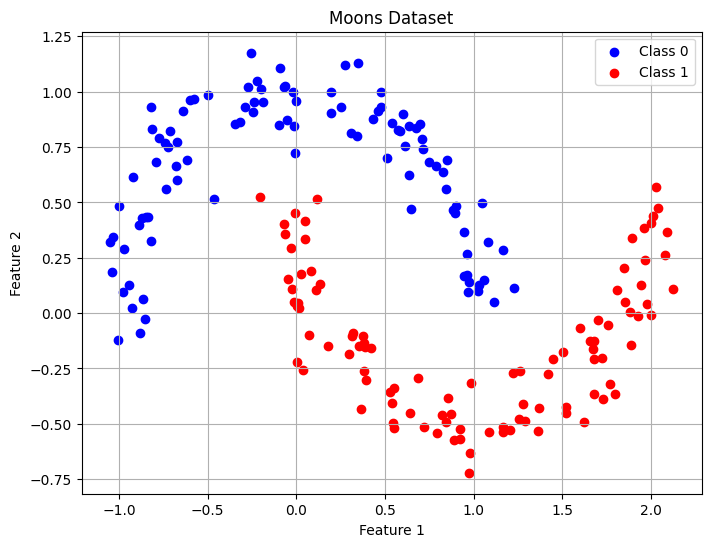

Best Kernel for moons: rbf
Accuracy: 1.0, ROC-AUC: 1.0


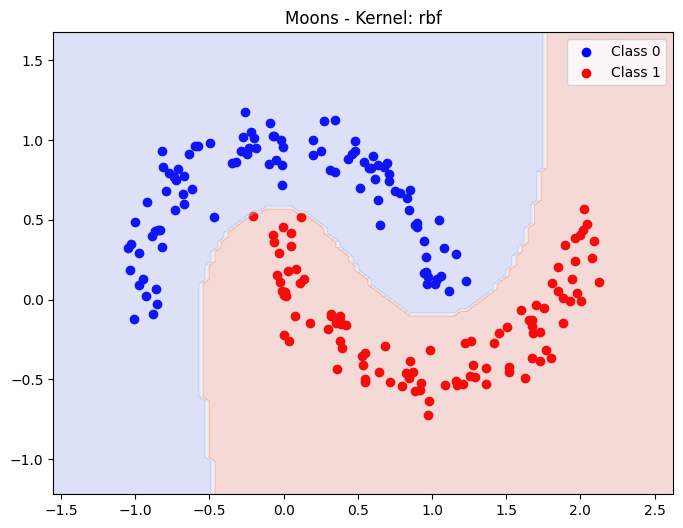

In [60]:
# generate and analyze moons dataset
explorer.analyze_and_visualize('moons', n_samples=200, noise=0.1, random_state=1)


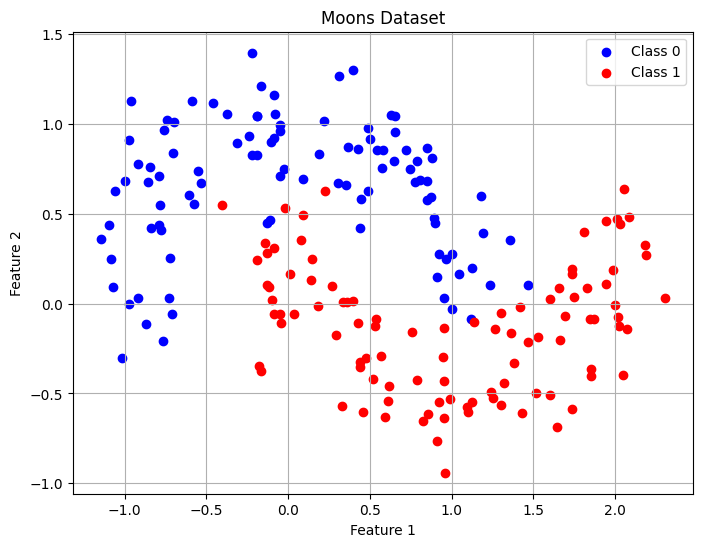

Best Kernel for moons: rbf
Accuracy: 0.95, ROC-AUC: 0.9932659932659933


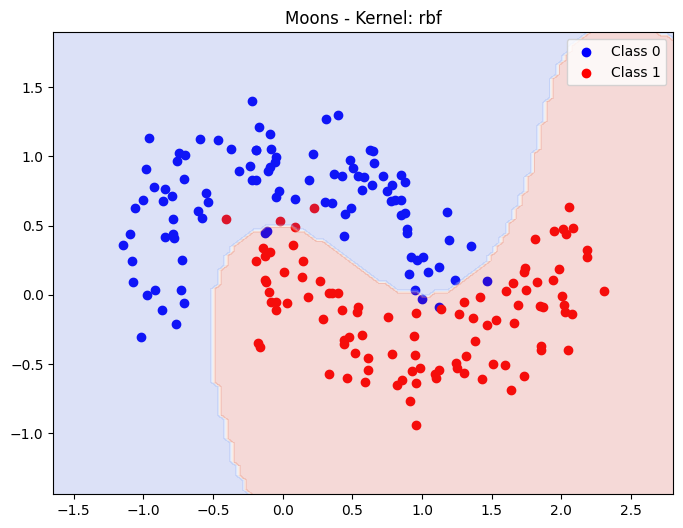

In [61]:
explorer.analyze_and_visualize('moons', n_samples=200, noise=0.2, random_state=1)


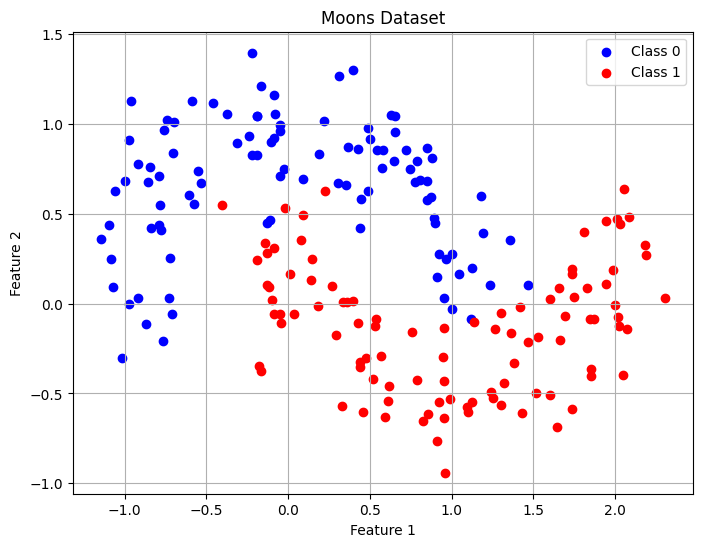

Best Kernel for moons: rbf
Accuracy: 0.95, ROC-AUC: 0.9932659932659933


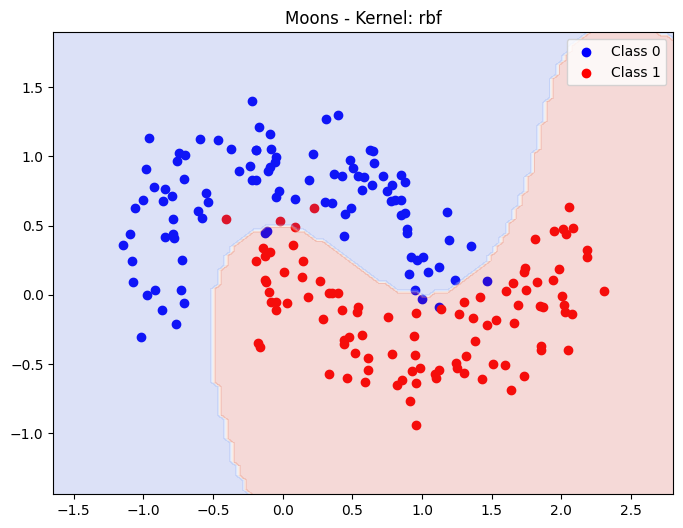

In [62]:
explorer.analyze_and_visualize('moons', n_samples=200, noise=0.2, random_state=1)


### 5. Evaluate the Kernels and Noise

In [63]:
df_results = explorer.evaluate_kernels_with_noise()
print(df_results)

     Kernel  Accuracy   ROC-AUC  Dataset  Noise
0    linear  0.883333       N/A    moons    0.1
1      poly  0.916667  0.974186    moons    0.1
2       rbf  1.000000       1.0    moons    0.1
3   sigmoid  0.600000  0.784512    moons    0.1
4    linear  0.866667       N/A    moons    0.2
5      poly  0.883333  0.962963    moons    0.2
6       rbf  0.950000  0.993266    moons    0.2
7   sigmoid  0.666667  0.808081    moons    0.2
8    linear  0.866667       N/A    moons    0.3
9      poly  0.883333  0.956229    moons    0.3
10      rbf  0.933333  0.969697    moons    0.3
11  sigmoid  0.666667  0.813692    moons    0.3
12   linear  0.450000       N/A  circles    0.1
13     poly  0.450000  0.514029  circles    0.1
14      rbf  0.800000  0.975309  circles    0.1
15  sigmoid  0.500000  0.483726  circles    0.1
16   linear  0.450000       N/A  circles    0.2
17     poly  0.500000   0.59147  circles    0.2
18      rbf  0.600000  0.804714  circles    0.2
19  sigmoid  0.533333  0.476992  circles

In [64]:
# Apply with kfold cross validation
df_cross_val_results = explorer.evaluate_kernels_with_noise_cross_validation(
    dataset_names=['moons', 'circles'], 
    noise_levels=[0.1, 0.2, 0.3], 
    k=5
)

print("CV Results:\n", df_cross_val_results)

Cross-Validated Results:
      Kernel  Dataset  Noise  k-Fold CV Accuracy
0    linear    moons    0.1               0.880
1      poly    moons    0.1               0.925
2       rbf    moons    0.1               1.000
3   sigmoid    moons    0.1               0.655
4    linear    moons    0.2               0.875
5      poly    moons    0.2               0.880
6       rbf    moons    0.2               0.955
7   sigmoid    moons    0.2               0.630
8    linear    moons    0.3               0.850
9      poly    moons    0.3               0.835
10      rbf    moons    0.3               0.910
11  sigmoid    moons    0.3               0.630
12   linear  circles    0.1               0.385
13     poly  circles    0.1               0.470
14      rbf  circles    0.1               0.830
15  sigmoid  circles    0.1               0.530
16   linear  circles    0.2               0.400
17     poly  circles    0.2               0.585
18      rbf  circles    0.2               0.635
19  sigmoid  c

### 6. Explain Solution

* The first observation is that the RBF kernel consistently outperformed other kernels. It achieved a pretty high accuracy and ROC-AUC, especially for the moons dataset. This infers that the RBF kernel is well-suited for handling non-linear boundaries present in both moons and circles.
* The moons dataset is generally easier to classify than the circles dataset, as shown by the higher accuracy and ROCAUC scores for most kernels and noise levels. Even with increased noise, the RBF kernel maintained pretty good performance for moons, suggesting it adapts well to moderately noisy data.
* In the circles dataset the RBF kernel performed significantly better than other kernels, but its performance declined with increased noise levels. We increased the noise gradually to see the differences there. This pattern shows that while the RBF kernel can capture circular boundaries, higher noise levels degrade its effectiveness.
* Linear and polynomial kernels struggled with both datasets as shown in the results above, particularly the circles dataset, where linear separability is not sufficient. The moons dataset, while slightly better used to these kernels, still required non-linear approaches for the best classification results. We used the noise here to really test the robustness of the models.
